# Anomaly Detection with NILMTK

Trying to implement the following paper:
#### Appliance-Level Anomaly Detection in Nonintrusive Load Monitoring via Power Consumption-Based Feature Analysis! <br><br>


## "Operation Mode Extraction"


<br><br>
### A) Getting and Preprocessing Dataset [X]<br>
##### I) Get the aggregated power signal [X]<br><br>

### B) Event Detection [X]<br>
If the difference between two consecutive samples exceeds a certain threshold <br>
##### I) Implementing the three-point method [X]
##### II) Data up-sample to a second [X]
<br><br>
### C) Proposed Event-based States Detection [ ]<br>
##### I) three-point event detection [X]
##### II) The dataset of events is defined [ ]
##### III) K-means clustering [X]
<br><br>

# Importing libraries

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\nijao\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\nijao\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\nijao\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Pre-Processing the Dataset

In [2]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('C:/data/redd.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[1].elec

### Choosing the training target

In [3]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input


print(train_elec.submeters())
train_meter = train_elec.submeters()['electric stove'] # The microwave meter that is used as a training target

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=14, building=1, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)])
  ElecMeter(insta

### Helper Functions

In [4]:
def _normalize(chunk, mmax):
    '''Normalizes timeseries

    Parameters
    ----------
    chunk : the timeseries to normalize
    max : max value of the powerseries

    Returns: Normalized timeseries
    '''
    tchunk = chunk / mmax
    return tchunk

In [5]:
def apply_on_chunk(mainchunk, meterchunk, epochs=5, batch_size=8, window_size=1):
    '''Train using only one chunk

    Parameters
    ----------
    mainchunk : chunk of site meter
    meterchunk : chunk of appliance
    epochs : number of epochs for training
    batch_size : size of batch used for training
    '''

    print("mainchunk  : ",np.shape(mainchunk))
    
    # Replace NaNs with 0s
    mainchunk.fillna(0, inplace=True)
    meterchunk.fillna(0, inplace=True)
    ix = mainchunk.index.intersection(meterchunk.index)
    mainchunk = np.array(mainchunk[ix])
    meterchunk = np.array(meterchunk[ix])

    
    print("mainchunk  : ",np.shape(mainchunk))
    
    indexer = np.arange(window_size)[None, :] + np.arange(len(mainchunk)-window_size+1)[:, None]
    mainchunk = mainchunk[indexer]
    meterchunk = meterchunk[window_size-1:]
    mainchunk = np.reshape(mainchunk, (mainchunk.shape[0], mainchunk.shape[1],1))

    #self.model.fit(mainchunk, meterchunk, epochs=epochs, batch_size=batch_size, shuffle=True)
    return mainchunk, meterchunk




def convert_time(timestamp):
    return pd.to_datetime(timestamp, unit='ms')

def get_second(date):
    return date.second

def get_minute(date):
    return date.minute

def get_hour(date):
    return date.hour

def get_day(date):
    return date.day

def get_month(date):
    return date.month

def get_year(date):
    return date.year


### Loading the dataset into mainchunk and meterchunk

In [6]:
main_power_series  = train_mains.power_series()
meter_power_series = train_meter.power_series()
mmax = 1


    
# Train chunks
run = True
mainchunk = next(main_power_series)
meterchunk = next(meter_power_series)
if mmax == None:
    mmax = mainchunk.max()

while(run):
    
    mainchunk = _normalize(mainchunk, mmax)
    meterchunk = _normalize(meterchunk, mmax)

    #self.train_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    try:
        mainchunk = next(main_power_series)
        meterchunk = next(meter_power_series)
        print("1")
        mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk, epochs, batch_size)
    except Exception as e:
        print(e)
        run = False
                

In [7]:
mainchunks, meterchunks = apply_on_chunk(mainchunk, meterchunk)

print("mainchunks  : ",np.shape(mainchunks))

print("meterchunks : ",np.shape(meterchunks))

mainchunk  :  (830117,)
mainchunk  :  (215567,)
mainchunks  :  (215567, 1, 1)
meterchunks :  (215567,)


In [8]:
df_main  = mainchunk.to_frame()  
df_meter = meterchunk.to_frame()

df_main['power appliance'] = df_meter

df_main.columns =['power apparent','power appliance']

df_meter = df_main['power appliance']



df_main["power appliance"].fillna("0", inplace = True)
df_main = df_main.reset_index()

df_main.columns =['date','power apparent','power appliance']


df_main['second']   = df_main['date'].apply(get_second)
df_main['minute']   = df_main['date'].apply(get_minute)
df_main['hour']   = df_main['date'].apply(get_hour)
df_main['day']    = df_main['date'].apply(get_day)
df_main['month']  = df_main['date'].apply(get_month)
df_main['year']   = df_main['date'].apply(get_year)

In [9]:
df_main.head(10)

,date,power apparent,power appliance,second,minute,hour,day,month,year
0,2011-04-18 09:22:09-04:00,224.190002,0,9,22,9,18,4,2011
1,2011-04-18 09:22:10-04:00,225.570007,0,10,22,9,18,4,2011
2,2011-04-18 09:22:11-04:00,226.089996,0,11,22,9,18,4,2011
3,2011-04-18 09:22:12-04:00,222.740005,0,12,22,9,18,4,2011
4,2011-04-18 09:22:13-04:00,222.199997,0,13,22,9,18,4,2011
5,2011-04-18 09:22:14-04:00,222.110001,0,14,22,9,18,4,2011
6,2011-04-18 09:22:15-04:00,223.139999,0,15,22,9,18,4,2011
7,2011-04-18 09:22:16-04:00,223.169998,0,16,22,9,18,4,2011
8,2011-04-18 09:22:17-04:00,222.250000,0,17,22,9,18,4,2011
9,2011-04-18 09:22:18-04:00,222.639999,0,18,22,9,18,4,2011


In [10]:
df = df_main['date'].to_frame()
df['year'] = df_main['year']
df['month'] = df_main['month']
df['day'] = df_main['day']
df['hour'] = df_main['hour']
df['minute'] = df_main['minute']
df['second'] = df_main['second']
df['power apparent'] = df_main['power apparent']
df['power appliance'] = df_main['power appliance']

In [11]:
df.head(10) # dataset already to the second

,date,year,month,day,hour,minute,second,power apparent,power appliance
0,2011-04-18 09:22:09-04:00,2011,4,18,9,22,9,224.190002,0
1,2011-04-18 09:22:10-04:00,2011,4,18,9,22,10,225.570007,0
2,2011-04-18 09:22:11-04:00,2011,4,18,9,22,11,226.089996,0
3,2011-04-18 09:22:12-04:00,2011,4,18,9,22,12,222.740005,0
4,2011-04-18 09:22:13-04:00,2011,4,18,9,22,13,222.199997,0
5,2011-04-18 09:22:14-04:00,2011,4,18,9,22,14,222.110001,0
6,2011-04-18 09:22:15-04:00,2011,4,18,9,22,15,223.139999,0
7,2011-04-18 09:22:16-04:00,2011,4,18,9,22,16,223.169998,0
8,2011-04-18 09:22:17-04:00,2011,4,18,9,22,17,222.250000,0
9,2011-04-18 09:22:18-04:00,2011,4,18,9,22,18,222.639999,0


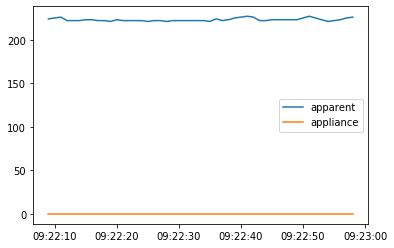

In [12]:
appliance = df['power appliance'][:50].astype(int)
apparent = df['power apparent'][:50].astype(int)
time = df['date'][:50]

fig, ax = plt.subplots()
ax.plot(time, apparent, label="apparent")
ax.plot(time, appliance, label="appliance")
ax.legend()

plt.show()

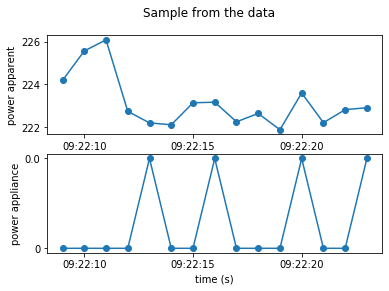

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Sample from the data')

ax1.plot(df['date'][:15], df['power apparent'][:15], 'o-')
ax1.set_ylabel('power apparent')

ax2.plot(df['date'][:15], df['power appliance'][:15].astype(str), 'o-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('power appliance')

plt.show()

# Up-sampling the data to 1 Second
<br>
Current dataframe is 1 sec resolution already. Therefore, we won't apply the following method

In [15]:
def min_to_sec_data(value1, value2):
    
    diff = (value2-value1)/60
    val = value1
    points = [value1]
    
    for i in range(60):
        val += diff#(diff/60)*i
        points.append(val)
    return points

#min_to_sec_data(200,210)

In [48]:
mainchunk.values
uppsampled_mainchunks = []

for i in range(0,len(mainchunk.values)-1,2):
    uppsampled_mainchunks.append(min_to_sec_data(mainchunk.values[i],mainchunk.values[i+1]))

In [49]:
uppsampled_mainchunks = np.array(uppsampled_mainchunks)

In [50]:
uppsampled_mainchunks = np.reshape(uppsampled_mainchunks, (uppsampled_mainchunks.shape[0]*uppsampled_mainchunks.shape[1],1))
uppsampled_mainchunks

array([[224.19000244],
       [224.21300252],
       [224.2360026 ],
       ...,
       [129.11932882],
       [129.11966197],
       [129.11999512]])

In [51]:
print(uppsampled_mainchunks.shape)

(25318538, 1)


# Three-Point Method
"utilizes the local mean and deviation of the data and is free of
said threshold."

### Calculating local mean of P(t)

In [16]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def local_mean_range(P):
    d = np.array(P)

    consec = 3
    offset = 0
    nsub = 1
    pace = 1

    s = d.strides[0]
    ngroups= (d.shape[0] - (consec + (nsub-1)*offset - 1))//pace
    a = as_strided(d, shape=(ngroups, nsub, consec),
                   strides=(pace*s, offset*s, 1*s))

    local_mean = a.mean(axis=-1).mean(axis=-1)
    return local_mean[0]

def deviation_range(P):
    return np.std(P)

mean = local_mean_range(P=[10,5,5])
dev  = deviation_range(P=[10,5,5])

def event_detected(P):
    detected = True
    
    return detected

print("Computing for [10,5,5]\n")
print('local mean\t   deviation\t\tvariance\t\taverage')
print(mean, dev, np.var([10,5,5]), np.average([10,5,5]))

Computing for [10,5,5]

local mean	   deviation		variance		average
6.666666666666667 2.357022603955158 5.5555555555555545 6.666666666666667


### Creating the methods for reconstruction and three point method

In [17]:
def three_point_method(P, P_s=[]):
    """
    three point method which will be applied on the dataset alongside the reconstruct_P
    """
    P_bar  =  np.average(P)
    teta_p =  deviation_range(P)
    teta_g = deviation_range(P)
    
    try:
        ps_previous = P_s[-1]
    except:
        ps_previous = 0
    
    if teta_p > teta_g:
        P_s.append(ps_previous)
    else:
        P_s.append(P_bar)
        
    return P_s

def reconstruct_P(P, P_s=[0,0], T_q=[0,0],t='',P_events=[], N_events=[]):
    """
    P is our three points which are needed to calculate the deviation
    P_s is the cleaned new signal
    T_q is the new array that will contain the q events
    t is the time at which the event started
    """
    Event_Detected = False
    
    teta_g = deviation_range(P)
    try:
        delta_Ps = P_s[-1] - P_s[-2]
    except:
        if P_s[-1]:
            delta_Ps = P_s[-1]
        else:
            delta_Ps =0
    
    if delta_Ps>=teta_g:
        T_q.append(t)
        Event_Detected = True
        
        
    P_events.append(0)
    N_events.append(0)
    
    if delta_Ps>0:
        P_events[-1] = P_s[-1]
    elif delta_Ps<0:
        N_events[-1] = P_s[-1]
        
    return T_q, P_events, N_events


### Applying the three-point method + Pre-Processing on the dataset

In [18]:
from tqdm import tqdm
T_q = [df['date'][0]]
P_events, N_events = [],[]
P_s = []

for i in tqdm(range(0, len(df['power appliance']))):
    
    P = df['power appliance'][i:i+3].astype(float).values
    
    # Applying the three points method
    P_s = three_point_method(P, P_s)
    
    # Getting the event data
    T_q, P_events, N_events = reconstruct_P(P, P_s, T_q=T_q,t=df['date'][i],P_events=P_events, N_events=N_events)
    
    

100%|████████████████████████████████████████████████████████████████████████| 830117/830117 [04:06<00:00, 3367.07it/s]


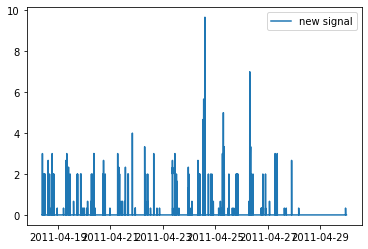

In [19]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()
ax.plot(df['date'], P_s, label="new signal")
ax.legend()

plt.show()

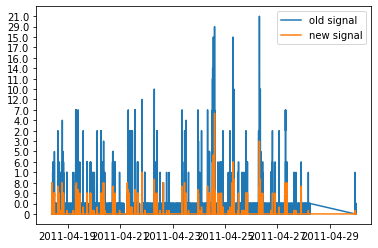

In [20]:
appliance = P_s
time = df['date'][:50]

fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")

ax.plot(df['date'], P_s, label="new signal")

ax.legend()

plt.show()

[0. 0. 0. ... 0. 0. 0.]


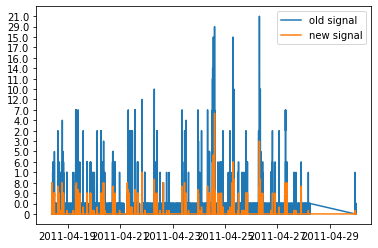

In [21]:
appliance = P_s
time = df['date'][:50]

P_string = np.array(P_s)#.dtype(np.int32)      # 32-bit integer
print(P_string)
fig, ax = plt.subplots()

ax.plot(df['date'], df['power appliance'].astype(str), label="old signal")
#ax.plot(df['date'][0:15], P_string[0:15], label="new signal")
ax.plot(df['date'], P_s, label="new signal")


ax.legend()

plt.show()

In [22]:
print(np.shape(P_s))
print(np.shape(T_q))

(830117,)
(810790,)


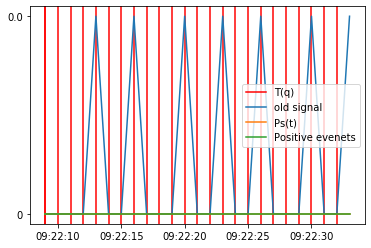

In [23]:
appliance = P_s
time = df['date'][:50]

#df_temp = pd.DataFrame(np.array(T_q[:50]), columns=list('abc'))
# pd.to_datetime(T_q[:50].datetime)

fig, ax = plt.subplots()

plt.axvline(T_q[0], color='red', label="T(q)")

for i in range(1,25):
    plt.axvline(T_q[i], color='red')
    
ax.plot(df['date'][:25], df['power appliance'][:25].astype(str), label="old signal")

ax.plot(df['date'][:25], P_s[:25], label="Ps(t)")
ax.plot(df['date'][:25], P_events[:25], label="Positive evenets")





    
ax.legend()

plt.show()

### Define the set of events (positive and negative)
<br>
For example going energy turning on will be positive while off will be negative

In [25]:
df['new signal'] = np.array(P_s)#.to_frame()  P_events  positive events

In [26]:
df.head(10)

,date,year,month,day,hour,minute,second,power apparent,power appliance,positive events,new signal
0,2011-04-18 09:22:09-04:00,2011,4,18,9,22,9,224.190002,0,0.0,0.0
1,2011-04-18 09:22:10-04:00,2011,4,18,9,22,10,225.570007,0,0.0,0.0
2,2011-04-18 09:22:11-04:00,2011,4,18,9,22,11,226.089996,0,0.0,0.0
3,2011-04-18 09:22:12-04:00,2011,4,18,9,22,12,222.740005,0,0.0,0.0
4,2011-04-18 09:22:13-04:00,2011,4,18,9,22,13,222.199997,0,0.0,0.0
5,2011-04-18 09:22:14-04:00,2011,4,18,9,22,14,222.110001,0,0.0,0.0
6,2011-04-18 09:22:15-04:00,2011,4,18,9,22,15,223.139999,0,0.0,0.0
7,2011-04-18 09:22:16-04:00,2011,4,18,9,22,16,223.169998,0,0.0,0.0
8,2011-04-18 09:22:17-04:00,2011,4,18,9,22,17,222.250000,0,0.0,0.0
9,2011-04-18 09:22:18-04:00,2011,4,18,9,22,18,222.639999,0,0.0,0.0


# K-Means Clustering

In [27]:
df_clust = df['new signal'].to_frame()
df_clust['power apparent'] = df['power apparent'] 

X = df_clust.values
X

array([[  0.        , 224.19000244],
       [  0.        , 225.57000732],
       [  0.        , 226.08999634],
       ...,
       [  0.        , 129.1000061 ],
       [  0.        , 129.11999512],
       [  0.        , 129.33999634]])

## Feature Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Applying PCA

## Using the elbow method to find the optimal number of clusters

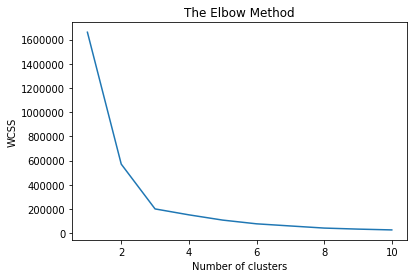

In [29]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We can see that 3 is the optimal number of states for this appliance

## Training the K-Means model on the dataset

In [30]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

## Visualising the clusters

### with processing the three-point method

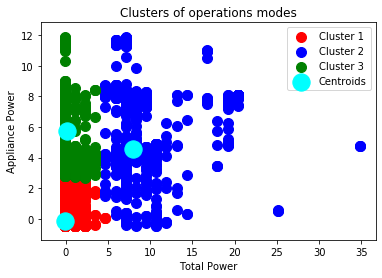

In [31]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()

### without processing the three-point method

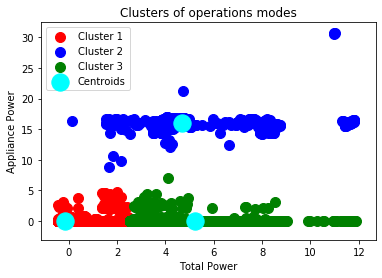

In [18]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'cyan', label = 'Centroids')
plt.title('Clusters of operations modes')
plt.xlabel('Total Power')
plt.ylabel('Appliance Power')
plt.legend()
plt.show()

In [19]:
# meterchunks = np.reshape(meterchunks, (np.shape(meterchunks)[0],1))
# meterchunks

In [20]:
# all_chunks = np.concatenate((mainchunk, meterchunk), axis=-1)
# all_chunks = np.reshape(all_chunks, (np.shape(meterchunks)[0],np.shape(meterchunks)[0]))


In [21]:
#df = pd.DataFrame(data=all_chunks, index=["row1", "row2"], columns=["date","time", "total power"])

In [31]:
# result = DataSet(disag_filename)
# res_elec = result.buildings[1].elec
# predicted = res_elec['microwave']
# ground_truth = test_elec['microwave']

# import matplotlib.pyplot as plt
# predicted.plot()
# ground_truth.plot()
# plt.show()

In [32]:
# import metrics
# rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))

# print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
# print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))